# Modeling and Simulation in Python

Chapter 11 Example: Throwing Axe

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# If you want the figures to appear in the notebook, 
# and you want to interact with them, use
# %matplotlib notebook

# If you want the figures to appear in the notebook, 
# and you don't want to interact with them, use
# %matplotlib inline

# If you want the figures to appear in separate windows, use
# %matplotlib qt5

# tempo switch from one to another, you have to select Kernel->Restart

%matplotlib notebook

from modsim import *

### Throwing axe

Our favorite event at Lumberjack Competitions is axe throwing.  The axes used for this event typically weigh 1.5 to 2 kg, with handles roughly 0.7 m long.  They are thrown overhead at a target typically 6 m away and 1.5 m off the ground.  Normally, the axe makes one full rotation in the air to hit the target blade first, with the handle close to vertical.

![Diagram of throwing axe](figs/throwingaxe1.png)

Here's a version of `make_system` that sets the initial conditions.

The state variables are x, y, theta, vx, vy, omega, where theta is the orientation (angle) of the axe in radians and omega is the angular velocity in radians per second.

I chose initial conditions based on videos of axe throwing.

In [2]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
radian = UNITS.radian

def make_system():
    """Makes a System object for the given conditions.
    
    returns: System with init, ...
    """
    P = Vector(0, 2) * m
    V = Vector(8, 4) * m/s
    
    init = State(x=P.x, y=P.y, theta=2, 
                 vx=V.x, vy=V.y, omega=-7)

    duration = 1.0 * s
    ts = linspace(0, duration, 101)
    
    return System(init=init, ts=ts,
                  g = 9.8 * m/s**2,
                  m = 1.5 * kg,
                  length = 0.7 * m)

Let's make a `System`

In [3]:
system = make_system()
system

,value
init,x 0.0 meter y ...
ts,"[0.0 second, 0.01 second, 0.02 second, 0.03 se..."
g,9.8 meter / second ** 2
m,1.5 kilogram
length,0.7 meter


In [4]:
system.init

,value
x,0.0 meter
y,2.0 meter
theta,2
vx,8.0 meter / second
vy,4.0 meter / second
omega,-7


As a simple starting place, I ignore drag, so `vx` and `omega` are constant, and `ay` is just `-g`.

In [5]:
def slope_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with length0, m, k
    
    returns: sequence (vx, vy, ax, ay)
    """
    x, y, theta, vx, vy, omega = state
    unpack(system)

    ax = 0
    ay = -g
    alpha = 0

    return vx, vy, omega, ax, ay, alpha

As always, let's test the slope function with the initial conditions.

In [6]:
slope_func(system.init, 0, system)

(<Quantity(8.0, 'meter / second')>,
 <Quantity(4.0, 'meter / second')>,
 -7,
 0,
 <Quantity(-9.8, 'meter / second ** 2')>,
 0)

And then run the simulation.

In [7]:
%time run_odeint(system, slope_func)

CPU times: user 96 ms, sys: 0 ns, total: 96 ms
Wall time: 92.7 ms


### Visualizing the results

We can extract xs, ys, and thetas as `Series` objects.

In [8]:
xs = system.results.x
ys = system.results.y
thetas = system.results.theta

The simplest way to visualize the results is to plot the state variables as a function of time.

<IPython.core.display.Javascript object>


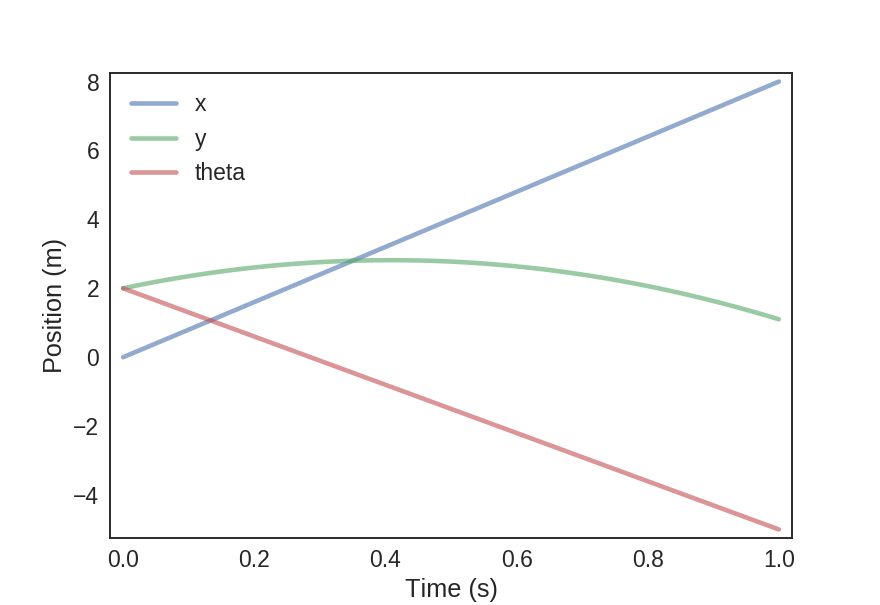

In [9]:
newfig()
plot(xs, label='x')
plot(ys, label='y')
plot(thetas, label='theta')

decorate(xlabel='Time (s)',
         ylabel='Position (m)')

We can plot the velocities the same way.

In [10]:
vxs = system.results.vx
vys = system.results.vy
omegas = system.results.omega

<IPython.core.display.Javascript object>


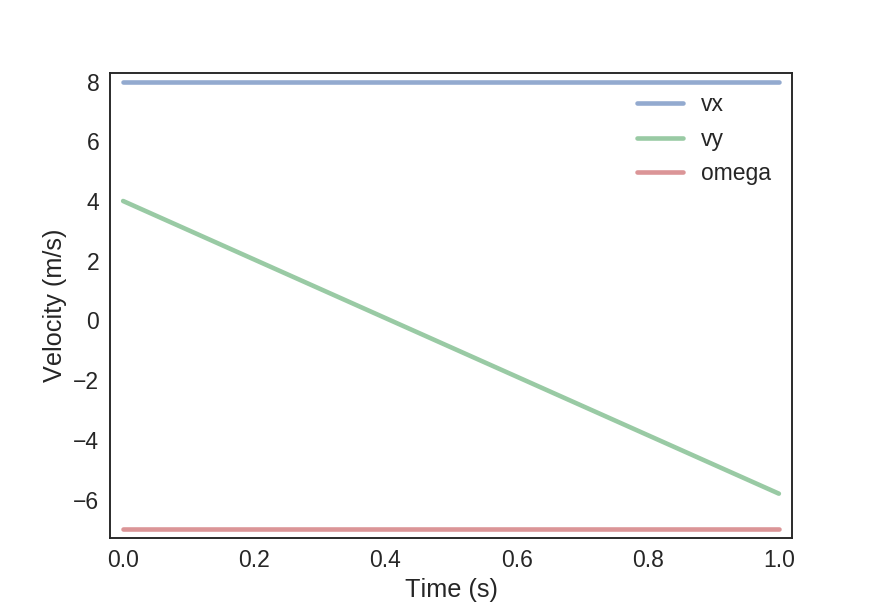

In [11]:
newfig()
plot(vxs, label='vx')
plot(vys, label='vy')
plot(omegas, label='omega')

decorate(xlabel='Time (s)',
         ylabel='Velocity (m/s)')

Another way to visualize the results is to plot y versus x.  The result is the trajectory through the plane of motion.

<IPython.core.display.Javascript object>


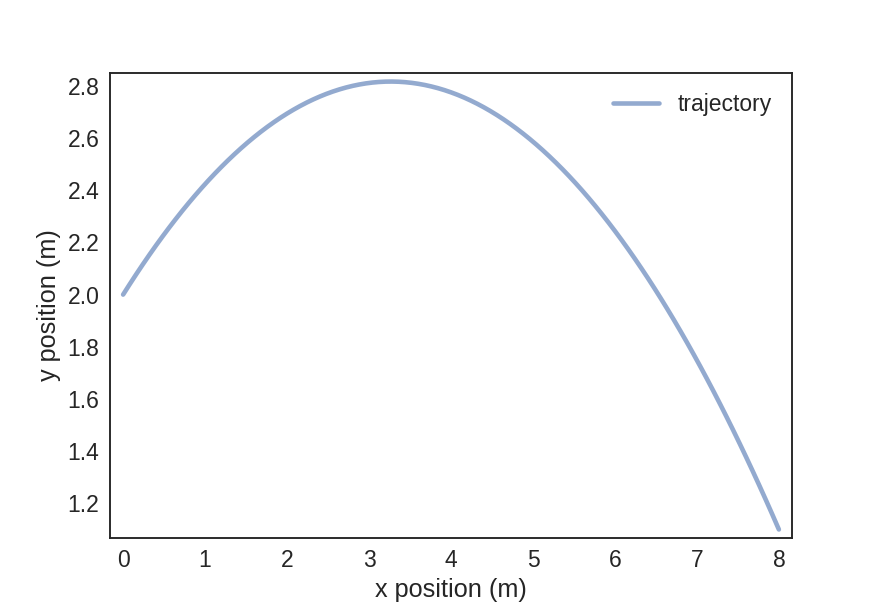

In [12]:
newfig()
plot(xs, ys, label='trajectory')

decorate(xlabel='x position (m)',
         ylabel='y position (m)')

Animating this system is a little more complicated, if we want to show the shape and orientation of the axe.

It is useful to construct a frame with $\hat{r}$ along the handle of the axe and $\hat{\theta}$ perpendicular.

In [13]:
def make_frame(theta):
    rhat = Vector(pol2cart(theta, 1))
    that = rhat.perp()
    return rhat, that

Now we're ready to animate the results.  The following figure shows the frame and the labeled points A, B, C, and D.

![Diagram of the axe with reference frame](figs/throwingaxe2.png)

<IPython.core.display.Javascript object>


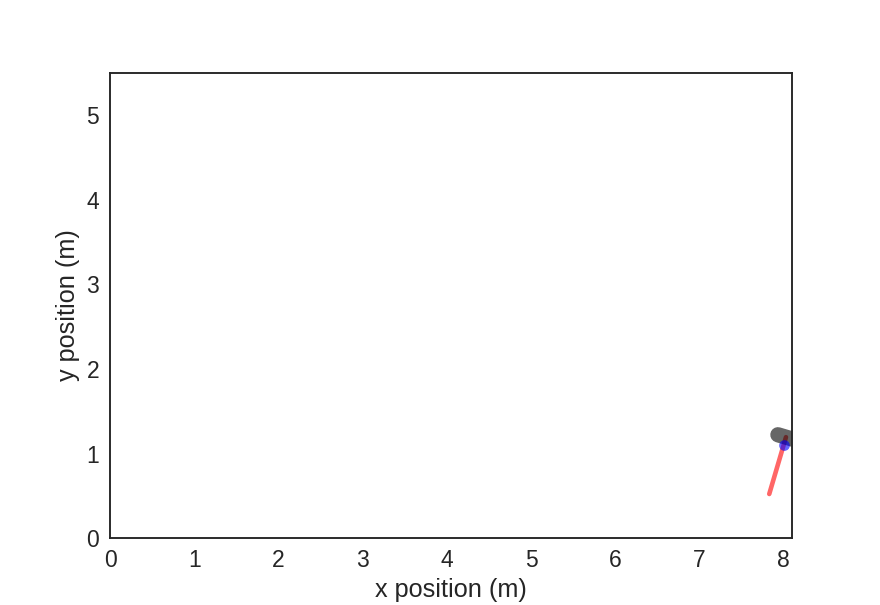

In [14]:
newfig()
decorate(xlabel='x position (m)',
         ylabel='y position (m)',
         xlim=[0, 8.1],
         ylim=[0, 5.5],
         legend=False)

# l1 and l2 are the lengths of the handle below and above
# the center of gravity (COG)
l1 = 0.6
l2 = 0.1

for t, state in system.results.iterrows():
    x, y, theta, vx, vy, omega = state
    P = Vector(x, y)
    rhat, that = make_frame(theta)
    
    # plot the handle
    A = P - l1 * rhat
    B = P + l2 * rhat
    plot_segment(A, B, color='red', update=True)

    # plot the axe head
    C = B + l2 * that
    D = B - l2 * that
    plot_segment(C, D, color='black', linewidth=10, update=True)

    # plot the COG
    plot(x, y, 'bo', update=True)
    sleep(0.01)

During the animation, the parts of the axe seem to slide around relative to each other.  I think that's because the lines and circles get rounded off to the nearest pixel.

Here's the final state of the axe at the point of impact (assuming the target is 8 m away).

In [15]:
state

x        8.0
y        1.1
theta   -5.0
vx       8.0
vy      -5.8
omega   -7.0
Name: 1.0, dtype: float64

**Exercise:**  Find the starting conditions that make the final height of the COG as close as possible to 1.5 m.  Ideally, the final angle should be a little past vertical.

**Exercise:**  Compute the total velocity of the leading edge of the axe at the point of impact, that is, the sum of velocity due to translation and rotation.

<IPython.core.display.Javascript object>


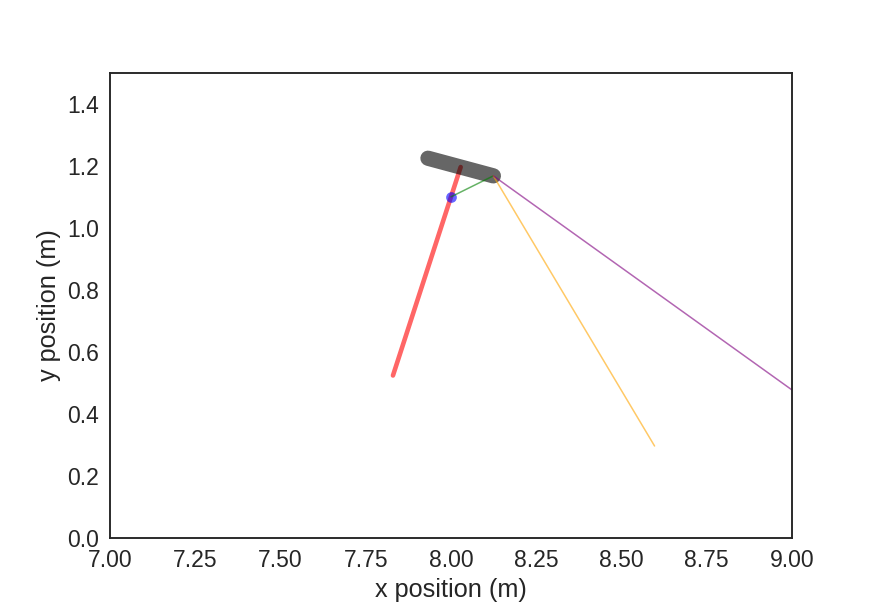

<Quantity(10.782983699109682, 'dimensionless')>

In [16]:
# Solution

newfig()
decorate(xlabel='x position (m)',
         ylabel='y position (m)',
         xlim=[7, 9],
         ylim=[0, 1.5],
         legend=False)

# quick, get those state variables into Vector objects!
x, y, theta, vx, vy, omega = state
P = Vector(x, y)
V = Vector(vx, vy)
rhat, that = make_frame(theta)
    
# plot the handle
A = P - l1 * rhat
B = P + l2 * rhat
plot_segment(A, B, color='red', update=True)

# plot the axe head
C = B + l2 * that
D = B - l2 * that
plot_segment(C, D, color='black', linewidth=10, update=True)

# plot the COG
plot(x, y, 'bo', update=True)
    
plot_segment(P, D, color='green', linewidth=1, update=True)

# compute the velocity of point D due to rotation
R = D - P
VrotD = omega * R.perp()

plot_segment(D, D+VrotD, color='orange', linewidth=1, update=True)

# add in the velocity due to translation
Vtot = VrotD + V
plot_segment(D, D+Vtot, color='purple', linewidth=1, update=True)

# print the magnitude of velocity at the point of contact
Vtot.mag